In [ ]:
using DrWatson

In [2]:
@quickactivate
projectname()

"NowcastingHuascaran"

In [3]:
using PyCall
using Serialization
using ClimateBase
using Plots

In [4]:
tf = pyimport("tensorflow")
keras = pyimport("tensorflow.keras")
model = keras.models.load_model("../artifacts/model.h5")

2022-01-28 17:15:00.912132: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-28 17:15:00.915234: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


PyObject <tensorflow.python.keras.engine.functional.Functional object at 0x00000000A6044D90>

In [10]:
ds_path = datadir("exp_pro", "GLM-L2-LCFA_8km_5m_boxes", "2019", "jls")
ds = deserialize(readdir(ds_path; join=true)[1])

19-element Vector{<:ClimArray}:
 ClimArray (named flash_extent_density) with 64×64×288 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×32 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×25 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×47 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×135 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×132 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×103 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×76 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×117 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×97 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×30 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×27 Lon×Lat×Time data
 ClimArray (named flash_extent_density) with 64×64×110 Lon×Lat×Time data
 ClimArray (named flash_ex

In [6]:
function animation(ds)
    anim = @time @animate for i = 1:size(ds, 3)
        heatmap(ds[:,:,i], c=cgrad([:black, :white]), legend=false, size=(480,480), clim=(0,15))
    end
    gif(anim, fps=4)
end

animation (generic function with 1 method)

In [14]:
function animation_comparation(ds, ds2, fps)
    anim = @time @animate for i = 1:size(ds, 3)
        h1 = heatmap(ds[:,:,i], c=cgrad([:black, :white]), legend=false, clim=(0,5))
        h2 = heatmap(ds2[:,:,i], c=cgrad([:black, :white]), legend=false, clim=(0,10))
        plot(h1, h2, size=(480*2,480))
    end
    gif(anim, fps=fps)
end

animation_comparation (generic function with 1 method)

In [15]:
function animation_comparation_colors(ds, ds2, fps)
    anim = @time @animate for i = 1:size(ds, 3)
        h1 = heatmap(ds[:,:,i], c=cgrad([:black, :white]), legend=false, clim=(0,5))
        heatmap!(ds2[:,:,i], c=cgrad([:black, :yellow]), legend=false, clim=(0,10))
        plot(h1, size=(480,480))
    end
    gif(anim, fps=fps)
end

animation_comparation_colors (generic function with 1 method)

In [8]:
function rolling_predictions(model, dataset, n = 8, steps = 1)
    predicted = copy(dataset)
    for idx = 1:steps:size(dataset, 3) - 2n
        X = permutedims(reshape(dataset[:, :, idx:idx+n-1], (1, 64, 64, 8, 1)), (5,4,3,2,1))
        X_max = maximum(X)
        y = permutedims(model.predict(X / X_max), (5,4,3,2,1)) * X_max
        predicted[:, :, n+idx:idx+2n-1] = y[1, :, :, :, 1]
    end
    predicted
end

rolling_predictions (generic function with 3 methods)

In [9]:
using Flux

size(ds[i]) = (64, 64, 32)
  1.924231 seconds (12.38 M allocations: 313.153 MiB, 3.42% gc time)


┌ Info: Saved animation to 
│   fn = D:\Documents\VSCode\nowcasting-huascaran\notebooks\tmp.gif
└ @ Plots C:\Users\coolh\.julia\packages\Plots\FI0vT\src\animation.jl:114


Plots.AnimatedGif("D:\\Documents\\VSCode\\nowcasting-huascaran\\notebooks\\tmp.gif")
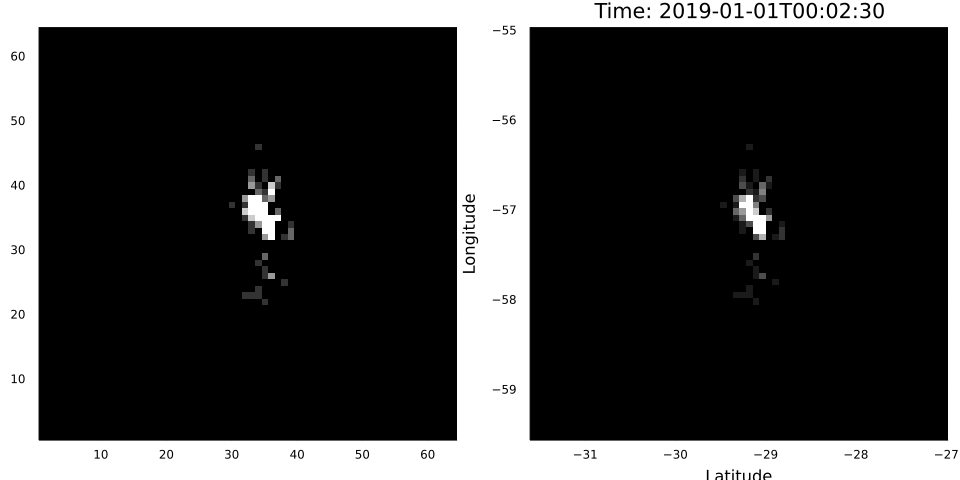

In [22]:
i = 2
@show size(ds[i])
dataset = ds[i].data
predicted = rolling_predictions(model, dataset, 8, 3);
animation_comparation(predicted, ds[i], 4)

  0.509669 seconds (3.10 M allocations: 78.432 MiB, 4.80% gc time)


┌ Info: Saved animation to 
│   fn = D:\Documents\VSCode\nowcasting-huascaran\notebooks\tmp.gif
└ @ Plots C:\Users\coolh\.julia\packages\Plots\FI0vT\src\animation.jl:114


Plots.AnimatedGif("D:\\Documents\\VSCode\\nowcasting-huascaran\\notebooks\\tmp.gif")
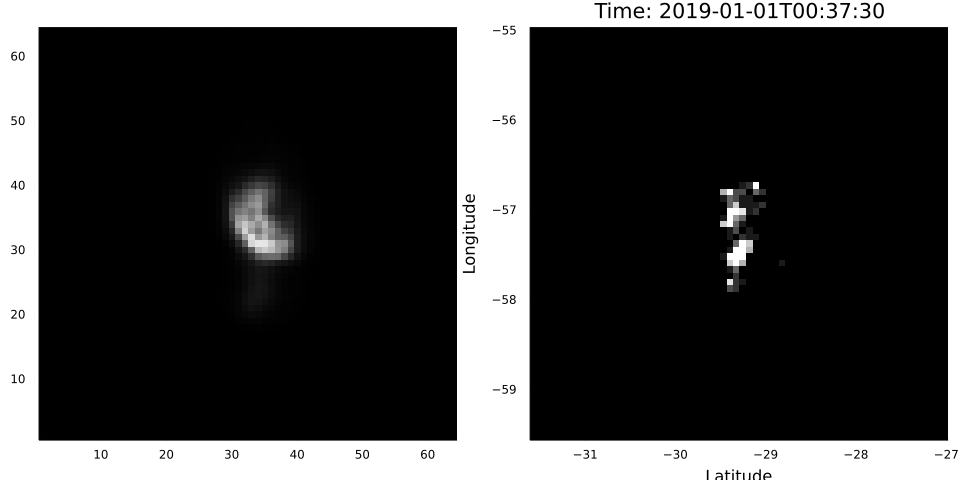

In [18]:
X, y = ds[i].data[:, :, 1:8], ds[i].data[:, :, 8:16]
X = permutedims(reshape(X, (1, 64, 64, 8, 1)), (5,4,3,2,1))
X_max = maximum(X)
y = permutedims(model.predict(X / X_max), (5,4,3,2,1)) * X_max
predicted_y = permutedims(model.predict(X / X_max), (5,4,3,2,1)) * X_max
predicted_y = predicted_y[1, :, :, :, 1]
animation_comparation((predicted_y), ds[i][:, :, 8:16], 2)

  0.976409 seconds (4.96 M allocations: 216.238 MiB, 6.65% gc time, 72.86% compilation time)


┌ Info: Saved animation to 
│   fn = D:\Documents\VSCode\nowcasting-huascaran\notebooks\tmp.gif
└ @ Plots C:\Users\coolh\.julia\packages\Plots\FI0vT\src\animation.jl:114


Plots.AnimatedGif("D:\\Documents\\VSCode\\nowcasting-huascaran\\notebooks\\tmp.gif")
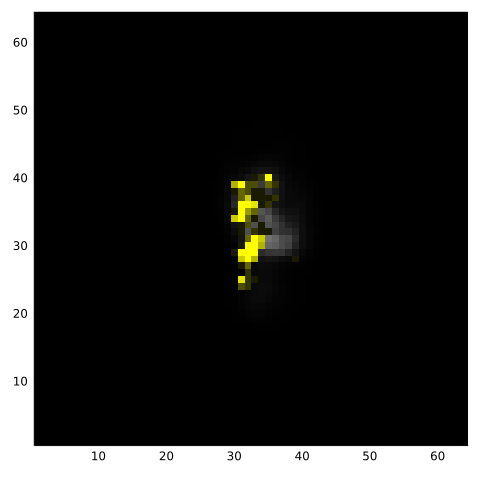

In [21]:
zerotonan(x) = x == 0 ? NaN : x
animation_comparation_colors((predicted_y), zerotonan.(ds[i][:, :, 8:16].data), 2)

In [120]:
using Images

In [ ]:
# Balancear el conjunto de datos respecto al maximo de densidad de rayos
# Grafica de residuales o scatterplot (diferencia del target vs. predicho en eje y, eje x valor target)

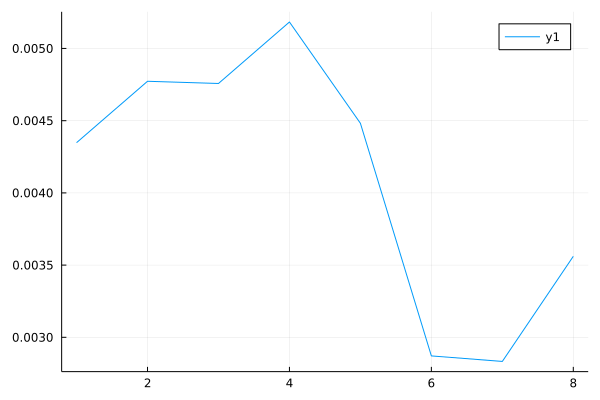

In [109]:
start = 50
X_ds, y = ds[i].data[:, :, start:start+n-1], ds[i].data[:, :, start+n:start+2n-1]
X = permutedims(reshape(X_ds, (1, 64, 64, 8, 1)), (5,4,3,2,1))
X_max = maximum(X)
ŷ = permutedims(model.predict(X / X_max), (5,4,3,2,1))
losses = [Flux.Losses.binarycrossentropy(ŷ[1,:,:,i,1], X_ds[:, :, i] / X_max) for i in 1:n]
plot(losses)

In [23]:
?Flux.Losses.binarycrossentropy

```
binarycrossentropy(ŷ, y; agg = mean, ϵ = eps(ŷ))
```

Return the binary cross-entropy loss, computed as

```
agg(@.(-y * log(ŷ + ϵ) - (1 - y) * log(1 - ŷ + ϵ)))
```

Where typically, the prediction `ŷ` is given by the output of a [`sigmoid`](@ref) activation. The `ϵ` term is included to avoid infinity. Using [`logitbinarycrossentropy`](@ref) is recomended over `binarycrossentropy` for numerical stability.

Use [`label_smoothing`](@ref) to smooth the `y` value as preprocessing before computing the loss.

See also: [`crossentropy`](@ref), [`logitcrossentropy`](@ref).

# Examples

```jldoctest
julia> y_bin = Bool[1,0,1]
3-element Vector{Bool}:
 1
 0
 1

julia> y_prob = softmax(reshape(vcat(1:3, 3:5), 2, 3) .* 1f0)
2×3 Matrix{Float32}:
 0.268941  0.5  0.268941
 0.731059  0.5  0.731059

julia> Flux.binarycrossentropy(y_prob[2,:], y_bin)
0.43989f0

julia> all(p -> 0 < p < 1, y_prob[2,:])  # else DomainError
true

julia> y_hot = Flux.onehotbatch(y_bin, 0:1)
2×3 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  ⋅
 1  ⋅  1

julia> Flux.crossentropy(y_prob, y_hot)
0.43989f0
```
